In [1]:
from pypinyin import lazy_pinyin, Style
import torch

MODELS = {
    'vqvae.pth':'/home/hyc/tortoise_plus_zh/ttts/vqvae/logs/2023-10-31-02-33-25/model-12.pt',
    'gpt.pth': '/home/hyc/tortoise_plus_zh/ttts/gpt/logs/2023-10-30-14-32-24/model-2.pt',
    'clvp2.pth': '',
    'diffusion.pth': '/home/hyc/tortoise_plus_zh/ttts/diffusion/logs/2023-10-27-00-00-28/model-12.pt',
    'vocoder.pth': '/home/hyc/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin',
    'rlg_auto.pth': '',
    'rlg_diffuser.pth': '',
}

In [2]:
from ttts.gpt.voice_tokenizer import VoiceBpeTokenizer
import torch.nn.functional as F
device = 'cuda:1'
# text = "大家好，今天来点大家想看的东西。"
text = "霞浦县衙城镇乌旗瓦窑村水位猛涨。"
pinyin = ' '.join(lazy_pinyin(text, style=Style.TONE3, neutral_tone_with_five=True))
tokenizer = VoiceBpeTokenizer('gpt/gpt_tts_tokenizer.json')
text_tokens = torch.IntTensor(tokenizer.encode(pinyin)).unsqueeze(0).to(device)
text_tokens = F.pad(text_tokens, (0, 1))  # This may not be necessary.
text_tokens = text_tokens.to(device)
print(pinyin)
print(text_tokens)

xia2 pu3 xian4 ya2 cheng2 zhen4 wu1 qi2 wa3 yao2 cun1 shui3 wei4 meng3 zhang3 。
tensor([[ 62, 162,   2,  24,  60,   2, 167,   2,  33, 162,   2, 147,   2,  53,
         150,   2,  31,  80,   2,  25,  58,   2,  31, 125,   2,  33, 194,   2,
          11,  29,  91,   2, 246,  59,   2, 140,   2,  21, 238,   2,  53,  92,
           2,  39,   0]], device='cuda:1', dtype=torch.int32)


In [3]:
from ttts.utils.infer_utils import load_model
from ttts.vocoder.feature_extractors import MelSpectrogramFeatures
import torchaudio
# device = 'gpu:0'
gpt = load_model('gpt',MODELS['gpt.pth'],'gpt/config.json',device)
gpt.post_init_gpt2_config(use_deepspeed=False, kv_cache=False, half=False)
# diffusion = load_model('diffusion',MODELS['diffusion.pth'],'ttts/diffusion/config.json',device)
cond_audio = '0.wav'
audio,sr = torchaudio.load(cond_audio)
if audio.shape[0]>1:
    audio = audio[0].unsqueeze(0)
audio = torchaudio.transforms.Resample(sr,24000)(audio)
cond_mel = MelSpectrogramFeatures()(audio).to(device)
print(cond_mel.shape)

/home/hyc/miniconda3/envs/vocos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hyc/miniconda3/envs/vocos/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


torch.Size([1, 100, 433])


In [19]:
auto_conditioning = cond_mel
settings = {'temperature': .8, 'length_penalty': 1.0, 'repetition_penalty': 2.0,
                    'top_p': .8,
                    'cond_free_k': 2.0, 'diffusion_temperature': 1.0}
top_p = .8
temperature = .8
autoregressive_batch_size = 1
length_penalty = 2.0
repetition_penalty = 2.0
max_mel_tokens = 600
print(auto_conditioning.shape)
print(text_tokens.shape)
codes = gpt.inference_speech(auto_conditioning, text_tokens,
                                do_sample=True,
                                top_p=top_p,
                                temperature=temperature,
                                num_return_sequences=autoregressive_batch_size,
                                length_penalty=length_penalty,
                                repetition_penalty=repetition_penalty,
                                max_generate_length=max_mel_tokens)
print(codes)

torch.Size([1, 100, 433])
torch.Size([1, 45])
tensor([[ 270,   92,   49,   98,    4,  110,   66,   47,   44,   22,  272,   31,
           60,   80,   12,  225,   50,   82,   18,    0,  131,  104,   55,   33,
            5,   73,  120,  115,   34,  137,   76,    4,  190,  239,   10,   36,
           69,   17,  123,  495,  128,   96,   42,  187,  156,   32,   35,   26,
            7,   15,  270,  225,   47,   47,  152,   28,  145,  146,  151,  209,
           41,   91,    6,    8,   78,   60,   41,   76,   76,  282,    2,   20,
           94,  272,   64,  182,   87,  239,   31,   13,   20,   50,   18,   18,
          120,  120,   50,   76,    4,   18,   18,   43,   94,   12,   98,   98,
           98, 8193]], device='cuda:1')


In [38]:
import torchaudio
from ttts.vocoder.feature_extractors import MelSpectrogramFeatures
vqvae = load_model('vqvae',MODELS['vqvae.pth'],'vqvae/config.json',device)

mel_extractor = MelSpectrogramFeatures().to(device)
audio,sr = torchaudio.load('0.wav')
audio = torchaudio.transforms.Resample(sr,24000)(audio).to(device)
mel = mel_extractor(audio)
print(mel)
codes = vqvae.get_codebook_indices(mel)
print(codes)

mel = vqvae.decode(codes)[0]
print(mel.max(),mel.min())

tensor([[[-4.3731, -4.0047, -4.0549,  ..., -3.8166, -5.5467, -4.4644],
         [-4.5036, -4.0154, -3.8274,  ..., -3.7270, -4.2473, -5.2711],
         [-3.8076, -3.8567, -4.0073,  ..., -4.3925, -4.3769, -4.5630],
         ...,
         [-5.4783, -5.3761, -5.4157,  ..., -5.5802, -5.6379, -5.8239],
         [-5.3949, -5.2930, -5.2571,  ..., -5.3609, -5.1319, -5.6430],
         [-5.8934, -5.6142, -5.5402,  ..., -5.2526, -4.6538, -5.2095]]],
       device='cuda:1')
tensor([[[-4.3731, -4.0047, -4.0549,  ..., -3.8166, -5.5467, -4.4644],
         [-4.5036, -4.0154, -3.8274,  ..., -3.7270, -4.2473, -5.2711],
         [-3.8076, -3.8567, -4.0073,  ..., -4.3925, -4.3769, -4.5630],
         ...,
         [-5.4783, -5.3761, -5.4157,  ..., -5.5802, -5.6379, -5.8239],
         [-5.3949, -5.2930, -5.2571,  ..., -5.3609, -5.1319, -5.6430],
         [-5.8934, -5.6142, -5.5402,  ..., -5.2526, -4.6538, -5.2095]]],
       device='cuda:1')
tensor([[[  2.9411, -32.1343,  49.0023,  ..., -15.4685,  12.5366,  2

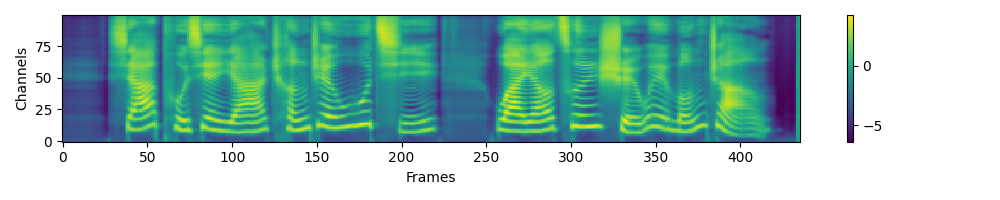

In [37]:
from PIL import Image
import numpy as np
from IPython.display import display
from ttts.utils.utils import plot_spectrogram_to_numpy
img = plot_spectrogram_to_numpy(mel[0, :, :].detach().unsqueeze(-1).cpu())
image = Image.fromarray(np.uint8(img))
display(image)